# Titanic Survived Passangers (Prediction)

by: Irfan Imaduddin <br>
date: 16 June 2022 <br>
ref: https://www.kaggle.com/competitions/titanic <br>
contact: irfanimaduddin[at]gmail.com <br>

---

## Package Setup

Import modules

In [1]:
import ipywidgets
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import catboost as cb

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

Read files

In [2]:
dataset_train = pd.read_csv("train.csv")
dataset_test = pd.read_csv("test.csv")
dataset_result = pd.read_csv("gender_submission.csv")

Inspect data

In [3]:
dataset_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
dataset_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The mean and median of the age distribution are 30 and 28


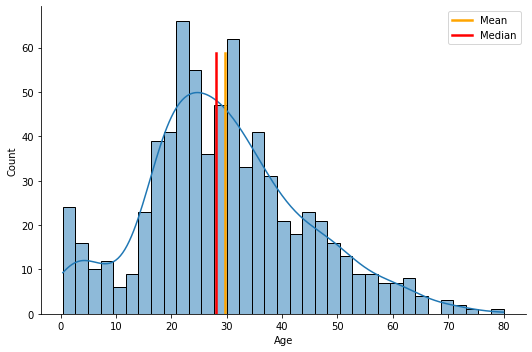

In [7]:
sns.displot(data=dataset_train, x='Age', kind="hist", bins=35, kde=True, fill=True, aspect=1.5)

plt.axvline(x=dataset_train['Age'].mean(), ymin=0, ymax=0.85, label='Mean', color="orange", linewidth=2.5)
plt.axvline(x=dataset_train['Age'].median(), ymin=0, ymax=0.85, label='Median', color="red", linewidth=2.5)

plt.legend()

print("The mean and median of the age distribution are {} and {}".format(round(dataset_train['Age'].mean()), round(dataset_train['Age'].median())))

### Summary

1. The **target** is **Survived** column which is a binary classification, `1` for survived passenger and `0` for not survived passenger. <br> <br>

2. **Feature types** <br>
    a. **Categorical** : Survived, Pclass, Sex, SibSp, Parch, Embarked <br>
    b. **Numerical** : PassengerId, Age, Fare <br>
    c. **Mixed** : Name, Ticket, Cabin <br> <br>
  
3. **What factors that make a person could survive from a sinking ship?** This will determine which columns will be used for the next steps. Let's breakdown each column by its description. <br>
    a. `PassengerId` is a sequential value that distinguishes each individual in the dataset we are dealing now. It is already represented by each row in the dataset. So, this column is <font color='red'>NOT A FACTOR</font> why someone can survive. <br>
    b. `Pclass` is a proxy for socio-economic status (SES) of each passenger. The values are `1`, `2` and `3` which represents for the first class (upper deck), the second class (middle deck) and the third class (lower deck), respectively. When a ship sinks, passengers on the upper deck will have a longer time to sink with the ship than on the middle or lower deck. It's a privilege. So, `Pclass` is <font color='green'>A FACTOR</font>. <br>
    c. `Name` describes the name of a passenger. Everyday, we know that celebrities and influential people will always get a "privilege" in various ways. But when it becomes a disaster, everyone has an equal chance to survive. So, this one is <font color='red'>NOT A FACTOR</font>. <br>
    d. `Sex`. As we know, men are actually stronger than women. This is a "stereotype". But somehow men can use their strength for rescuing themselves or weaker people. `Sex` can be <font color='green'>A FACTOR</font> to determine who will survive. <br>
    e. `Age` is in years. Obviously we know that adults are more likely to have a chance to survive than babies, young children and the elderly. So, `Age` is <font color='green'>A FACTOR</font>. <br>
    f. `SibSp` is number of siblings or spouses aboard the Titanic. When a person sails with his/her relatives, there will be a tendency for that person to think about even saving them when a disaster happens. This could be <font color='green'>A FACTOR</font> for someone to survive on the Titanic. <br>
    g. `Parch` is number of parents or children aboard the Titanic. Same as `SibSp`, this also can be <font color='green'>A FACTOR</font> for someone to survive on the Titanic.<br>
    h. `Ticket` explains the ticket number owned by each passenger. This is not related actually and somehow it is already represented by `Pclass`. So, the ticket number is <font color='red'>NOT A FACTOR</font>. <br>
    i. `Fare` stands for passenger fare for a ticket. This feature is already represented by `Pclass`. So, this is <font color='red'>NOT A FACTOR</font>. <br>
    j. `Cabin` is the cabin number for each passenger. This feature is also already represented by `Pclass`. So, this is <font color='red'>NOT A FACTOR</font>. <br>
    k. `Embarked` represents port of embarkation for every passenger. The values are `C`, `Q` and `S` which stands for Cherbourg, Queenstown and Southampton, respectively. For some people, this feature is not a factor. But what if the place where a person came from has a culture of activity that makes him/her stronger than people from other places? So, in my opinion this will be <font color='green'>A FACTOR</font>. <br>
    

## Data Cleaning

In [8]:
df_train = dataset_train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]
df_test = dataset_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Embarked  418 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 19.7+ KB


Fill NaN values in `Age` with its average

In [11]:
df_train['Age'].fillna(df_train['Age'].mean(),inplace = True)
df_test['Age'].fillna(df_test['Age'].mean(),inplace = True)

Fill NaN values in `Embarked` with random choice of embarked values.

In [12]:
embarked_val = ['C', 'Q', 'S']

np.random.seed(2022)
df_train["Embarked"].fillna(np.random.choice(embarked_val), inplace =True)

Changing data types

In [13]:
df_train['Survived'] = df_train['Survived'].astype('category')
df_train['Pclass'] = df_train['Pclass'].astype('category')
df_train['Sex'] = df_train['Sex'].astype('category')
df_train['Embarked'] = df_train['Embarked'].astype('category')

df_test['Pclass'] = df_test['Pclass'].astype('category')
df_test['Sex'] = df_test['Sex'].astype('category')
df_test['Embarked'] = df_test['Embarked'].astype('category')

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    category
 1   Pclass    891 non-null    category
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Embarked  891 non-null    category
dtypes: category(4), float64(1), int64(2)
memory usage: 25.0 KB


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    418 non-null    category
 1   Sex       418 non-null    category
 2   Age       418 non-null    float64 
 3   SibSp     418 non-null    int64   
 4   Parch     418 non-null    int64   
 5   Embarked  418 non-null    category
dtypes: category(3), float64(1), int64(2)
memory usage: 11.5 KB


## Some Visualizations (Univariate)

The survived passengers

Only 38.38% survived (total 891 passengers)


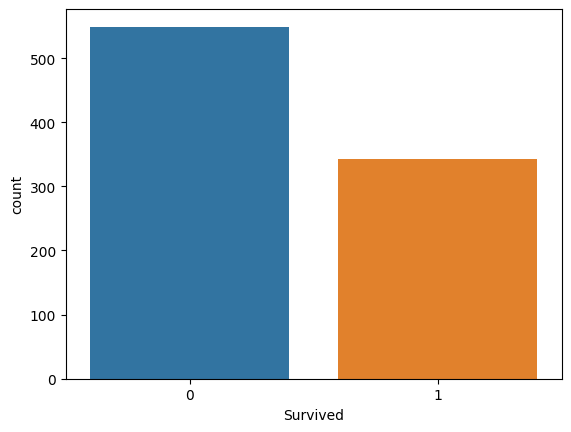

In [16]:
sns.countplot(data=df_train, x='Survived')

survived_percentage = np.round((len(df_train[df_train['Survived'] == 1])/len(df_train))*100, 2)

print("Only {}% survived (total {} passengers)".format(survived_percentage, len(df_train)))

The passenger classes

24.24% in the upper deck and 55.11% in the lower deck


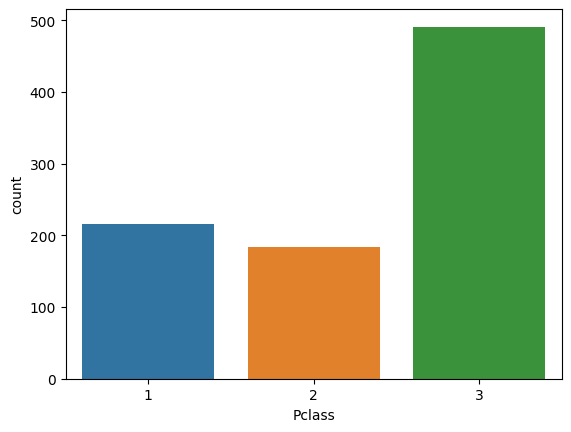

In [17]:
sns.countplot(data=df_train, x='Pclass')

first_class = np.round(len(df_train[df_train['Pclass'] == 1])/len(df_train)*100, 2)
second_class = np.round(len(df_train[df_train['Pclass'] == 2])/len(df_train)*100, 2)
third_class = np.round(len(df_train[df_train['Pclass'] == 3])/len(df_train)*100, 2)

print('{}% in the upper deck and {}% in the lower deck'.format(first_class, third_class))


The sex distribution

64.76% passengers are men (total 891 passengers)


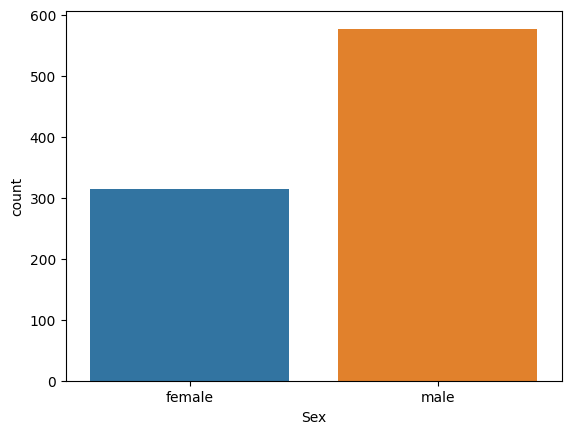

In [18]:
sns.countplot(data=df_train, x='Sex')

men_percentage = np.round((len(df_train[df_train['Sex'] == 'male'])/len(df_train))*100, 2)

print("{}% passengers are men (total {} passengers)".format(men_percentage, len(df_train)))

The age distribution

The average and median of age distribution are equal (about 29.7 years old)


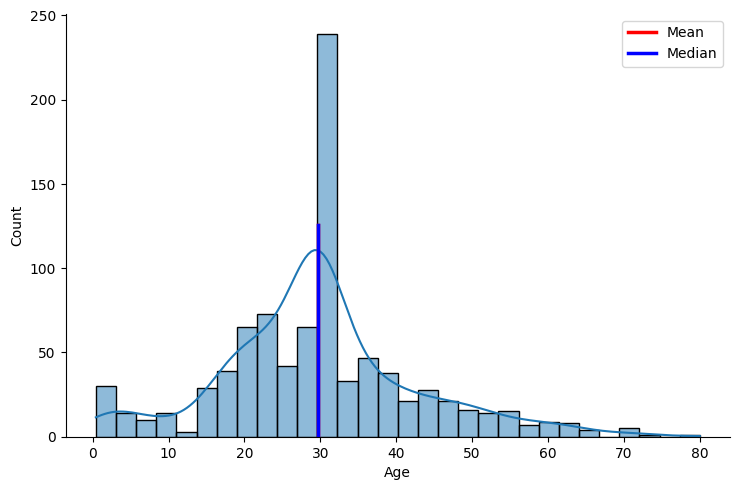

In [19]:
sns.displot(data=df_train, x='Age', kind="hist", kde=True, aspect=1.5)
plt.axvline(x=df_train['Age'].mean(), ymin=0, ymax=0.5, label='Mean', color="red", linewidth=2.5)
plt.axvline(x=df_train['Age'].median(), ymin=0, ymax=0.5, label='Median', color="blue", linewidth=2.5)
plt.legend()

print('The average and median of age distribution are equal (about {} years old)'.format(np.round(df_train['Age'].mean(), 2)))

Number of siblings or spouses

68.24% passengers have no siblings or spuouses on the Titanic (total 891 passengers)


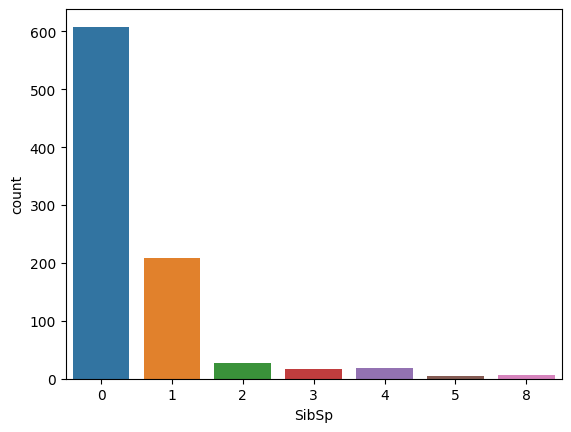

In [20]:
sns.countplot(data=df_train, x='SibSp')

nosiblings_percentage = np.round((len(df_train[df_train['SibSp'] == 0])/len(df_train))*100, 2)

print("{}% passengers have no siblings or spuouses on the Titanic (total {} passengers)".format(nosiblings_percentage, len(df_train)))

Number of parents or children

76.09% passengers have no parents or children on the Titanic (total 891 passengers)


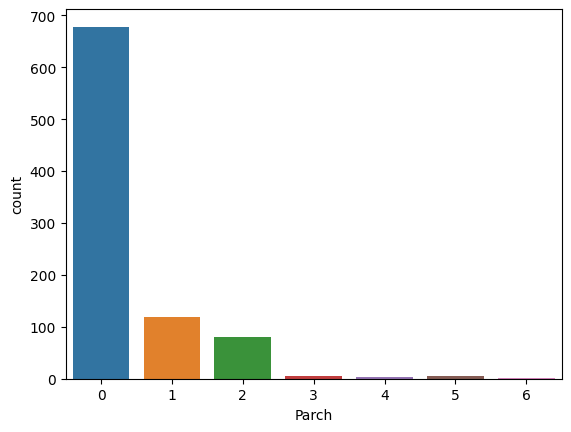

In [21]:
sns.countplot(data=df_train, x='Parch')

noparch_percentage = np.round((len(df_train[df_train['Parch'] == 0])/len(df_train))*100, 2)

print("{}% passengers have no parents or children on the Titanic (total {} passengers)".format(noparch_percentage, len(df_train)))

Location of embarkation

72.28% passengers were embarked from Southampton (total 891 passengers)


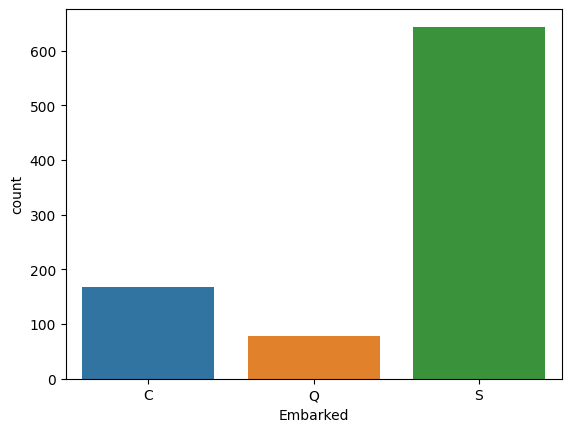

In [22]:
sns.countplot(data=df_train, x='Embarked')

most_embarked_percentage = np.round((len(df_train[df_train['Embarked'] == 'S'])/len(df_train))*100, 2)

print("{}% passengers were embarked from Southampton (total {} passengers)".format(most_embarked_percentage, len(df_train)))

## More Visualizations (Multivariate)

Survivors by `Pclass`

372 are not survived in lower deck and 136 are survived in upper deck


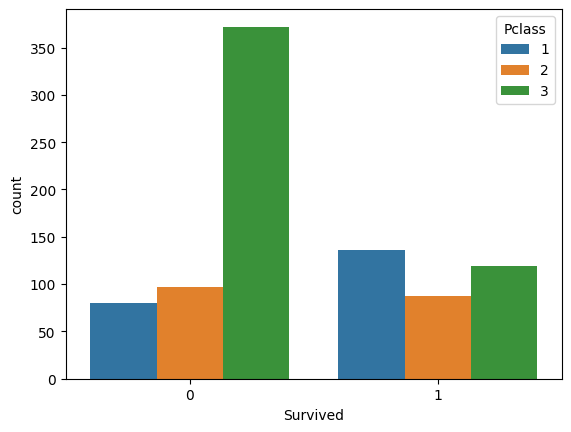

In [23]:
sns.countplot(df_train['Survived'], hue=df_train['Pclass']) 

notsurvived_lower = len(df_train[(df_train['Survived'] == 0) & (df_train['Pclass'] == 3)])
survived_upper = len(df_train[(df_train['Survived'] == 1) & (df_train['Pclass'] == 1)])

print('{} are not survived in lower deck and {} are survived in upper deck'.format(notsurvived_lower, survived_upper))

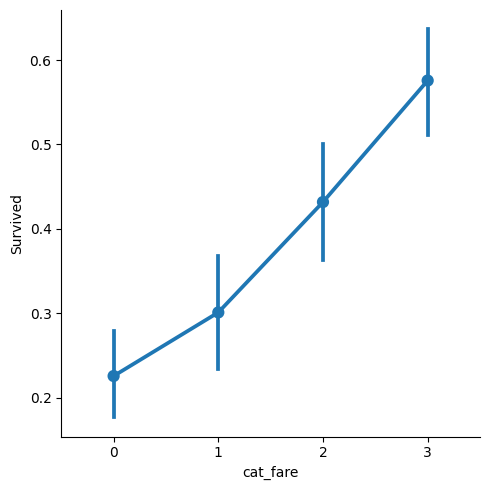

In [24]:
data = dataset_train

data['cat_fare'] = pd.cut(data['Fare'], bins=[0, 8, 14, 30, 400], labels=[0, 1, 2, 3])

sns.catplot(data=data, x='cat_fare',y='Survived',kind='point')

Survivors by `Sex`

468 men are not survived however 233 women are survived


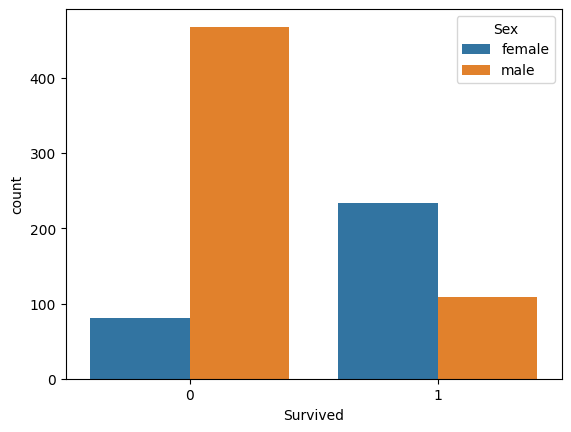

In [25]:
sns.countplot(df_train['Survived'], hue=df_train['Sex']) 

notsurvived_male = len(df_train[(df_train['Survived'] == 0) & (df_train['Sex'] == 'male')])
survived_women = len(df_train[(df_train['Survived'] == 1) & (df_train['Sex'] == 'female')])

print('{} men are not survived however {} women are survived'.format(notsurvived_male, survived_women))

Survivors by `Embarked`

55.36% passengers from Cherbourg were survived where most of passengers from other places were not


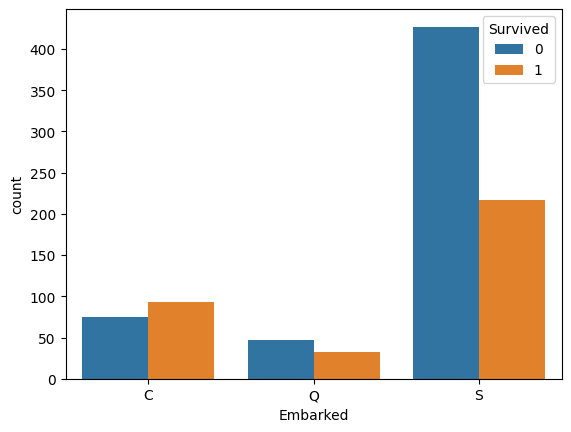

In [26]:
sns.countplot(df_train['Embarked'], hue=df_train['Survived']) 

cherbourg_survived = np.round(len(df_train[(df_train['Embarked'] == 'C') & (df_train['Survived'] == 1)])/len(df_train[df_train['Embarked'] == 'C'])*100, 2) 

print("{}% passengers from Cherbourg were survived where most of passengers from other places were not".format(cherbourg_survived))

Passenger classes by embarkation place

Passengers from Queenstown are mostly in the lower deck


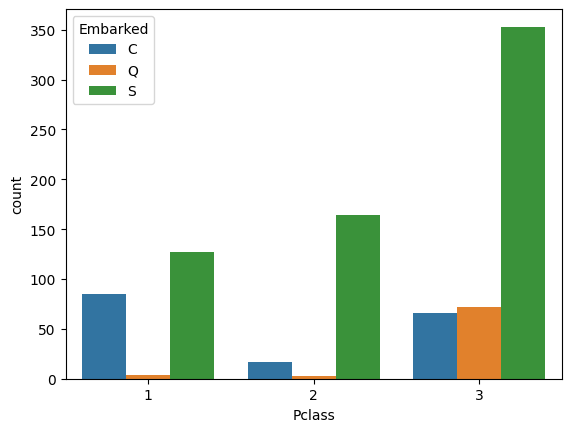

In [27]:
sns.countplot(df_train['Pclass'], hue=df_train['Embarked']) 

print('Passengers from Queenstown are mostly in the lower deck')

Survivors by `Age`

More than half passengers with age below 5 years old were survived


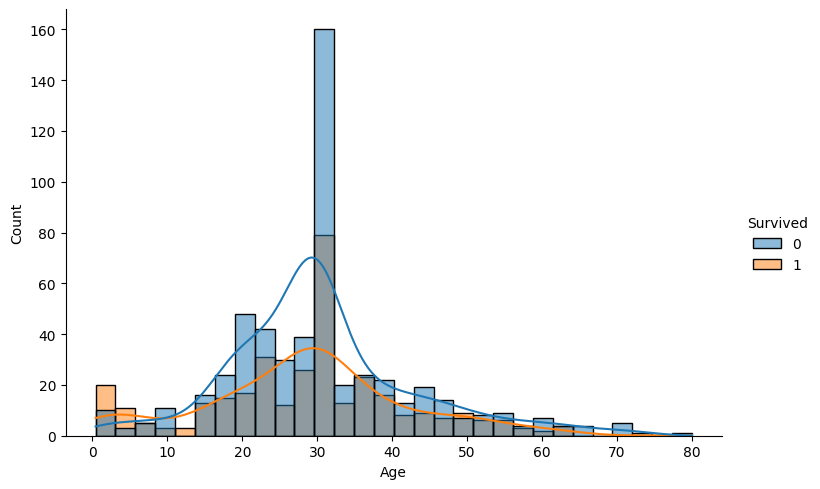

In [28]:
sns.displot(data=df_train, x='Age', hue="Survived", kind="hist", kde=True, fill=True, aspect=1.5)

print("More than half passengers with age below 5 years old were survived")

Survived passengers by `Age`

Text(0.5, 1.0, 'Survived passengers')

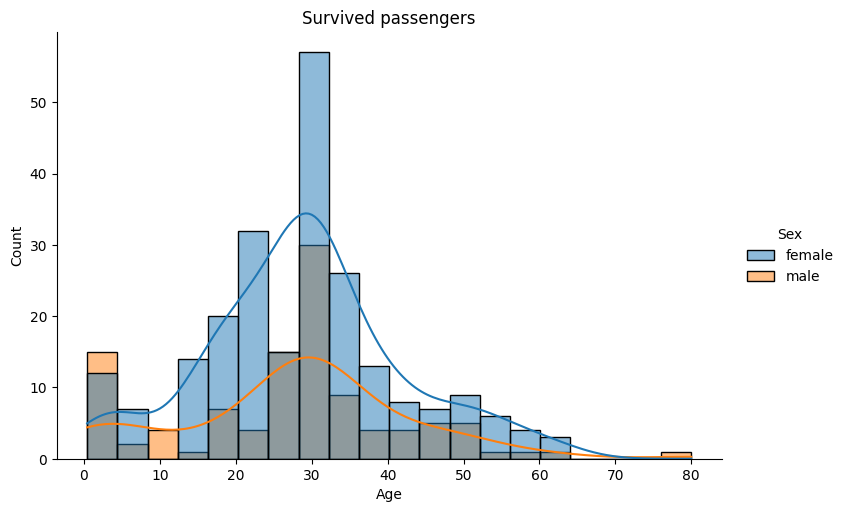

In [29]:
data = df_train[df_train['Survived'] == 1]

sns.displot(data=data, x='Age', hue="Sex", kind="hist", kde=True, fill=True, aspect=1.5)

plt.title("Survived passengers")
# print("More than half passengers with age below 5 years old were survived")

Correlation map

Relatives are least correlated (Siblings/spouses - Parents/children)


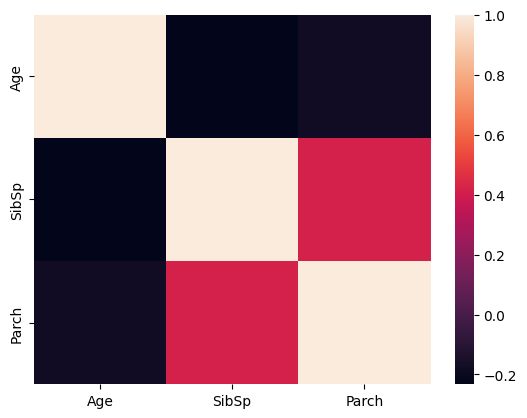

In [30]:
sns.heatmap(df_train.corr())

print("Relatives are least correlated (Siblings/spouses - Parents/children)")

## Features Engineering

**Feature types** <br>
    * **Categorical** : Survived, Pclass, Sex, SibSp, Parch, Embarked <br>
    * **Numerical** : Age <br>  
    
Let's encode `Sex` and `Embarked` by using **LabelEncoder** and rescale the `Age` by using **StandardScaler**.

In [31]:
encoder = LabelEncoder()
scaler = StandardScaler()

train_encoded_sex = encoder.fit_transform(df_train['Sex'].values)
train_encoded_embarked = encoder.fit_transform(df_train['Embarked'].values)
test_encoded_sex = encoder.fit_transform(df_test['Sex'].values)
test_encoded_embarked = encoder.fit_transform(df_test['Embarked'].values)

df_train['encoded_sex'] = train_encoded_sex
df_train['encoded_embarked'] = train_encoded_embarked
df_test['encoded_sex'] = test_encoded_sex
df_test['encoded_embarked'] = test_encoded_embarked

df_train['encoded_sex'] = df_train['encoded_sex'].astype('category')
df_train['encoded_embarked'] = df_train['encoded_embarked'].astype('category')
df_test['encoded_sex'] = df_test['encoded_sex'].astype('category')
df_test['encoded_embarked'] = df_test['encoded_embarked'].astype('category')

train_scaled_age = scaler.fit_transform(np.asarray(df_train['Age']).reshape(-1, 1))
test_scaled_age = scaler.fit_transform(np.asarray(df_test['Age']).reshape(-1, 1))

df_train['scaled_age'] = train_scaled_age.reshape(-1)
df_test['scaled_age'] = test_scaled_age.reshape(-1)

In [32]:
df_train = df_train.drop(['Sex', 'Embarked', 'Age'], axis=1)
df_test = df_test.drop(['Sex', 'Embarked', 'Age'], axis=1)

## Let's Get It Started!

### Logistic Regression (aka logit, MaxEnt) Classifier

Define independent and dependent (target) features

In [33]:
y = df_train['Survived']
X = df_train.drop('Survived', axis=1)

# Divide train dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2022)

Define the model

In [34]:
model = LogisticRegression(max_iter=1000, n_jobs=2, random_state=2022)

Fit the model

In [35]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=2, random_state=2022)

Predict the validation sets

In [36]:
predictions = model.predict(X_valid)

In [37]:
model.score(X_valid, y_valid)

0.8251121076233184

Checking the accuracy

In [38]:
accuracy_score(y_valid, predictions)

0.8251121076233184

In [39]:
confusion_matrix(y_valid, predictions)

array([[125,  18],
       [ 21,  59]], dtype=int64)

Predict the test set

In [40]:
test_predictions = model.predict(df_test)

In [41]:
accuracy_score(dataset_result['Survived'].values, test_predictions)

0.9401913875598086

In [42]:
confusion_matrix(dataset_result['Survived'].values, test_predictions)

array([[251,  15],
       [ 10, 142]], dtype=int64)

In [43]:
ds = pd.DataFrame({"PassengerId":dataset_test['PassengerId'].values,
                  "Survived": test_predictions,
                  })

In [44]:
ds.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


### CatBoostClassifier (Classification using Gradient Boosting on Decision Trees)

Define independent and dependent (target) features

In [45]:
y = df_train['Survived']
X = df_train.drop('Survived', axis=1)

# Divide train dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2022)

Define the model

In [46]:
model = cb.CatBoostClassifier(
    iterations=10,
    learning_rate=0.01,
    depth=5,
    loss_function="Logloss",
    eval_metric="Accuracy",
    random_state=2022
)

Fit the model

In [47]:
cat_features = ['Pclass', 'SibSp', 'Parch', 'encoded_sex', 'encoded_embarked']

In [48]:
model.fit(X_train, y_train, cat_features=cat_features, plot=False, eval_set=(X_valid, y_valid))

0:	learn: 0.7919162	test: 0.7802691	best: 0.7802691 (0)	total: 156ms	remaining: 1.4s
1:	learn: 0.7859281	test: 0.7892377	best: 0.7892377 (1)	total: 164ms	remaining: 658ms
2:	learn: 0.7859281	test: 0.7892377	best: 0.7892377 (1)	total: 173ms	remaining: 404ms
3:	learn: 0.7889222	test: 0.7937220	best: 0.7937220 (3)	total: 188ms	remaining: 282ms
4:	learn: 0.7904192	test: 0.7937220	best: 0.7937220 (3)	total: 202ms	remaining: 202ms
5:	learn: 0.7889222	test: 0.7937220	best: 0.7937220 (3)	total: 210ms	remaining: 140ms
6:	learn: 0.7829341	test: 0.8026906	best: 0.8026906 (6)	total: 220ms	remaining: 94.1ms
7:	learn: 0.7829341	test: 0.8026906	best: 0.8026906 (6)	total: 230ms	remaining: 57.5ms
8:	learn: 0.7814371	test: 0.8026906	best: 0.8026906 (6)	total: 240ms	remaining: 26.6ms
9:	learn: 0.7814371	test: 0.8026906	best: 0.8026906 (6)	total: 245ms	remaining: 0us

bestTest = 0.802690583
bestIteration = 6

Shrink model to first 7 iterations.


Predict the validation sets

In [49]:
predictions = model.predict(X_valid)

Checking the accuracy

In [50]:
accuracy_score(y_valid, predictions)

0.8026905829596412

In [51]:
confusion_matrix(y_valid, predictions)

array([[123,  20],
       [ 24,  56]], dtype=int64)

Predict the test set

In [52]:
test_predictions = model.predict(df_test)

In [53]:
accuracy_score(dataset_result['Survived'].values, test_predictions)

1.0

In [54]:
confusion_matrix(dataset_result['Survived'].values, test_predictions)

array([[266,   0],
       [  0, 152]], dtype=int64)

In [55]:
ds = pd.DataFrame({"PassengerId":dataset_test['PassengerId'].values,
                  "Survived": test_predictions,
                  })

In [56]:
ds.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Random Forest

In [57]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=2)